In [3]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras._tf_keras.keras.utils import pad_sequences

# Optimize gpu memory
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Load the dataset
file_path = '../../dataset_primer/lstm_dataset.csv'
df = pd.read_csv(file_path)

# Normalize the features (optional)
features = df.columns[:-3]  # Exclude 'segment_index', 'person_index', and 'label'
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
# Save the scaler for later use
scaler_filename = "lstm_scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Filter out rows with all zero keypoints or specific keypoints being zero
def filter_keypoints(row):
    keypoints = row[features].values
    if np.all(keypoints == 0):
        return False
    if np.any(keypoints[[features.get_loc(k) for k in [
        'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y',
        'left_hip_x', 'left_hip_y', 'right_hip_x', 'right_hip_y',
        'left_knee_x', 'left_knee_y', 'right_knee_x', 'right_knee_y',
        'left_ankle_x', 'left_ankle_y', 'right_ankle_x', 'right_ankle_y'
    ]]] == 0):
        return False
    return True

df = df[df.apply(filter_keypoints, axis=1)]

# Group by segment_index and person_index
grouped = df.groupby(['segment_index', 'person_index'])

# Create sequences
sequences = []
labels = []
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
for (segment_index, person_index), group in grouped:
    group_data = group[features].values
    label = group['label'].iloc[0]
    if label == "Walking":
        # Create sequences of 30 frames for each person_index
        for i in range(0, len(group_data), 30):
            seq = group_data[i:i + 30]
            if len(seq) == 30:
                sequences.append(seq)
                labels.append(label_mapping[label])
    else:
        sequences.append(group_data)
        labels.append(label_mapping[label])

# Pad sequences to the same length
max_timesteps = max(len(seq) for seq in sequences)
print(f"Maximum timesteps: {max_timesteps}")
sequences = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')

# Convert labels to numpy array
labels = np.array(labels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=123)

Maximum timesteps: 30


In [4]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dropout, Dense, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras._tf_keras.keras.optimizers import Adam

# Define the LSTM model
model = Sequential([
    # First Bidirectional LSTM layer with Conv1D + MaxPooling for feature extraction
    Conv1D(64, 3, activation='relu', padding='same', input_shape=(max_timesteps, len(features))),
    MaxPooling1D(2),
    BatchNormalization(),
    
    # Bidirectional LSTM for better learning of sequential data
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    # Second Bidirectional LSTM for deeper sequence learning
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    
    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.4),
    
    # Output layer for classification (using softmax for multi-class classification)
    Dense(len(label_mapping), activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.005, restore_best_weights=True, verbose=1)

/home/adamm1/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │         6,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 15, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 632,261 (2.41 MB)

 Trainable params: 632,133 (2.41 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# history = model.fit(X_train, y_train, epochs=400, validation_split=0.2, callbacks=[reduce_lr, early_stop])
history = model.fit(X_train, y_train, epochs=400, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/400


I0000 00:00:1732261461.485369  188057 cuda_dnn.cc:529] Loaded cuDNN version 90501


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6859 - loss: 0.8716 - val_accuracy: 0.7954 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 2/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8585 - loss: 0.3150 - val_accuracy: 0.8152 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 3/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8907 - loss: 0.2684 - val_accuracy: 0.8284 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 4/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8803 - loss: 0.2655 - val_accuracy: 0.7987 - val_loss: 0.6767 - learning_rate: 0.0010
Epoch 5/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9057 - loss: 0.2243 - val_accuracy: 0.8185 - val_loss: 0.9623 - learning_rate: 0.0010
Epoch 6/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9041 - loss: 0.2184 - val_accuracy: 0.8581 - val_loss: 0.2949 - learning_rate: 0.0010
Epoch 7/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9084 - loss: 0.2114 - val_accuracy: 0.83

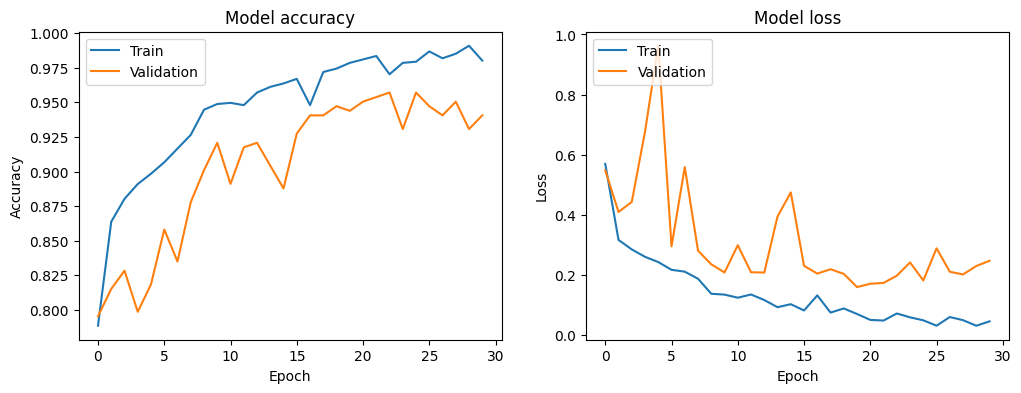

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


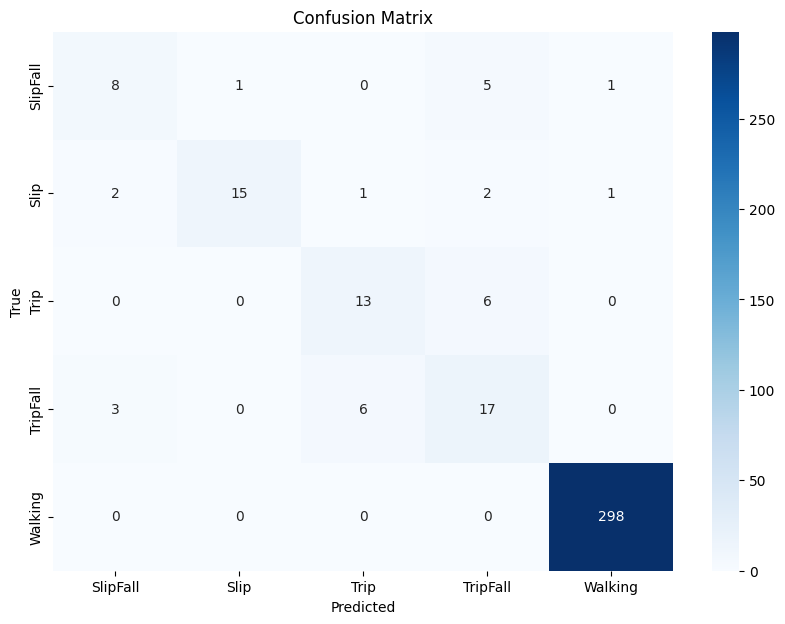

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [7]:
# Save the model
model.save('slip_fall_detector.keras')